# Hyperparameter Tuning for Super Vector Classifier (One vs. All)

In [1]:
# import libraries
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_theme(style="whitegrid")

In [2]:
try: #+ make things faster if possible
    from sklearnex import patch_sklearn
    patch_sklearn()
except Exception as e:
    print("skipping sklearnex")
    pass

skipping sklearnex


In [3]:
# import data
df = pd.read_csv('data/tracks_1000+.csv', index_col=False)
df.drop(columns={'Unnamed: 0'}, inplace=True)

In [4]:
del df["track_id"]; del df["artist_name"]; del df["track_name"]

In [5]:
# Make it 1000 for each category
result = df.groupby("genre").apply(lambda x: x.head(1000)).reset_index(drop=True)
result

,popularity,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,86,blues,0.743,0.446,4,-7.807,0,0.0683,0.00390,0.1180,0.3370,0.2780,123.596,232107,4
1,86,blues,0.743,0.446,4,-7.807,0,0.0683,0.00390,0.1180,0.3370,0.2780,123.596,232107,4
2,86,blues,0.743,0.446,4,-7.807,0,0.0683,0.00390,0.1180,0.3370,0.2780,123.596,232107,4
3,80,blues,0.636,0.676,2,-3.442,1,0.0263,0.08070,0.0000,0.0831,0.2730,113.980,208760,4
4,80,blues,0.636,0.676,2,-3.442,1,0.0263,0.08070,0.0000,0.0831,0.2730,113.980,208760,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,37,techno,0.714,0.621,9,-7.005,1,0.0893,0.20100,0.0192,0.0568,0.7450,114.237,331040,4
9996,34,techno,0.803,0.960,9,-3.342,0,0.0429,0.01570,0.0242,0.0566,0.5470,125.990,231271,4
9997,49,techno,0.880,0.477,0,-10.947,1,0.0732,0.00143,0.6270,0.0922,0.2090,125.017,539520,4
9998,47,techno,0.626,0.665,7,-10.134,0,0.0574,0.00775,0.7560,0.0811,0.0327,125.009,240000,4


## Training Preparation & Scaling

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

y_tmp = pd.DataFrame(result["genre"])
X = result.drop("genre", axis=1)
encoder = OneHotEncoder(sparse=False)
encoder.fit(y_tmp)
cols = [x.replace("x0_", "") for x in encoder.get_feature_names_out()]
display(len(cols))
y = pd.DataFrame(encoder.transform(y_tmp), columns=cols)
X_train_org, X_test_org, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)# , stratify=y > 0

/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


10

In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

def scaler_pipeline():
    return make_pipeline(SimpleImputer(strategy='constant', fill_value=0), RobustScaler())

def scaler_pipeline_pwr():
    return make_pipeline(SimpleImputer(strategy='constant', fill_value=0), RobustScaler(), PowerTransformer(method='yeo-johnson', standardize=True))

ct = ColumnTransformer([
        ('stdscaled', StandardScaler(), ["popularity","danceability","energy","key","loudness","mode","speechiness","acousticness","instrumentalness","liveness","valence","tempo","duration_ms","time_signature"]),
       ], remainder='passthrough')

X_train_scaled = ct.fit_transform(X_train_org)
X_test_scaled  = ct.transform(X_test_org)
X_train = X_train_scaled
X_test  = X_test_scaled

## Examine Parameters and Influences

In [8]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

### Training

In [9]:
cv_scores = {
    'genre': [],
    'score': []
}

test_scores_not_optimized = {}
for gen in y_train.columns:
    print('Genre:\t', gen)
    _model = SVC(random_state=42)
    _model.fit(X_train, y_train[gen])
    cv = cross_val_score(_model, X_train, y_train[gen], cv=3, scoring='accuracy')
    print('Cross validation score -> \t ', cv)
    cv_scores['genre'].append(gen)
    cv_scores['score'].append(cv)
    print('')
    test_scores_not_optimized[gen] = accuracy_score(y_test[gen], _model.predict(X_test))

cv_scores_df = pd.DataFrame.from_dict(cv_scores)

Genre:	 genre_blues
Cross validation score -> 	  [0.90251219 0.90101237 0.90097524]

Genre:	 genre_classical
Cross validation score -> 	  [0.99100112 0.98837645 0.98837209]

Genre:	 genre_electronic
Cross validation score -> 	  [0.90063742 0.89913761 0.89909977]

Genre:	 genre_funk
Cross validation score -> 	  [0.91976003 0.91938508 0.91822956]

Genre:	 genre_jazz
Cross validation score -> 	  [0.91451069 0.92275966 0.91822956]

Genre:	 genre_metal
Cross validation score -> 	  [0.8983877 0.8976378 0.8975994]

Genre:	 genre_r&b
Cross validation score -> 	  [0.90138733 0.90138733 0.90135034]

Genre:	 genre_rap
Cross validation score -> 	  [0.93775778 0.93475816 0.94223556]

Genre:	 genre_rock
Cross validation score -> 	  [0.90138733 0.90138733 0.90172543]

Genre:	 genre_techno
Cross validation score -> 	  [0.94525684 0.94300712 0.9456114 ]



In [10]:
cv_scores_df['score'] = cv_scores_df['score'].apply(lambda x: x.max()) # get max value of cross validation
cv_scores_df['genre'] = cv_scores_df['genre'].str.replace('genre_', '') # remove prefix
cv_scores_df

,genre,score
0,blues,0.902512
1,classical,0.991001
2,electronic,0.900637
3,funk,0.919760
4,jazz,0.922760
5,metal,0.898388
6,r&b,0.901387
7,rap,0.942236
8,rock,0.901725
9,techno,0.945611


In [11]:
# Test Score
test_scores_unoptimized_df = pd.DataFrame({"genre":[x.replace("genre_","") for x in test_scores_not_optimized.keys()], "score":test_scores_not_optimized.values()})
print("Score of Test Dataset")
test_scores_unoptimized_df

Score of Test Dataset


,genre,score
0,blues,0.8975
1,classical,0.9855
2,electronic,0.9080
3,funk,0.9125
4,jazz,0.9115
5,metal,0.9070
6,r&b,0.8945
7,rap,0.9310
8,rock,0.8940
9,techno,0.9565


In [12]:
def plot_validations(df, x, y, title):
    plt.figure(figsize=(9,7))
    plt.title(title)
    ax = sns.barplot(data=df, x=x, y=y)
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Genre');

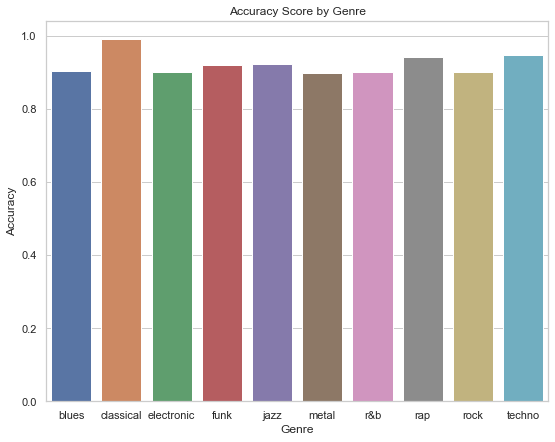

In [13]:
plot_validations(cv_scores_df, 'genre', 'score', 'Accuracy Score by Genre')

### Hyperparameter Optimization

In [14]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

In [15]:
svc = SVC() # model to be optimized
# c, gamma are hyperparameters of SVM

# parameters to be optimized
params_grid = {
    'C': np.arange(0.01, 1.5, 0.01),
    'gamma': np.arange(1, 12, 1)
}

# tuning parameters
n_iter = 100
cv = KFold(3, random_state=42, shuffle=True)
n_jobs = -1
scoring = 'accuracy'

In [16]:
svm_randomized_search = {
    'genre': [],
    'test-accuracy': []
}

start = time.time()
test_scores_of_optimized = {}
for genre in y_train.columns:
    print('Randomized Search for:\t ', genre)
    loop_start = time.time()
    _model = SVC(random_state=42)
    _random_search = RandomizedSearchCV(_model, params_grid, n_iter=n_iter, cv=cv, n_jobs=n_jobs, scoring=scoring, random_state=42, verbose=3)
    _random_search.fit(X_train, y_train[genre])
    _predictions_train = _random_search.best_estimator_.predict(X_train)
    _predictions = _random_search.best_estimator_.predict(X_test)
    _test_accuracy = round(accuracy_score(y_test[genre], _predictions), 4) * 100
    svm_randomized_search['genre'].append(genre)
    svm_randomized_search['test-accuracy'].append(accuracy_score(y_train[genre], _predictions_train))
    print(f'Test set Accuracy:\t {_test_accuracy}%.')
    loop_duration = round(time.time() - loop_start)
    print('Computation time:\t', loop_duration, ' seconds')
    test_scores_of_optimized[genre] = accuracy_score(y_test[genre], _predictions)
    print('Best estimators:\t', _random_search.best_estimator_)
    print('')

end = round(time.time() - start)
print('##########################################')
print('Total process duration:\t', end, ' seconds')

Randomized Search for:	  genre_blues
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Test set Accuracy:	 89.60000000000001%.
Computation time:	 99  seconds
Best estimators:	 SVC(C=0.25, gamma=8, random_state=42)

Randomized Search for:	  genre_classical
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Test set Accuracy:	 93.10000000000001%.
Computation time:	 95  seconds
Best estimators:	 SVC(C=1.34, gamma=1, random_state=42)

Randomized Search for:	  genre_electronic
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Test set Accuracy:	 91.05%.
Computation time:	 102  seconds
Best estimators:	 SVC(C=1.27, gamma=1, random_state=42)

Randomized Search for:	  genre_funk
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Test set Accuracy:	 90.7%.
Computation time:	 101  seconds
Best estimators:	 SVC(C=1.34, gamma=1, random_state=42)

Randomized Search for:	  genre_jazz
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Test

In [17]:
svm_randomized_search_df = pd.DataFrame.from_dict(svm_randomized_search)
svm_randomized_search_df

,genre,test-accuracy
0,genre_blues,0.901000
1,genre_classical,0.998875
2,genre_electronic,0.992375
3,genre_funk,0.973250
4,genre_jazz,0.901625
5,genre_metal,0.953750
6,genre_r&b,0.901375
7,genre_rap,0.967500
8,genre_rock,0.901500
9,genre_techno,0.996250


### Visualize difference between score before and after optimization

In [18]:
heatmap_diff = svm_randomized_search_df.copy()
heatmap_diff['test-accuracy'] = (heatmap_diff['test-accuracy'] - cv_scores_df['score']) * 100.0
heatmap_diff.index = heatmap_diff.genre.apply(lambda x: x.replace("genre_",""))
del heatmap_diff["genre"]
heatmap_diff.sort_values(by='test-accuracy', ascending=False, inplace=True)
heatmap_diff

,test-accuracy
genre,
electronic,9.173758
metal,5.536230
funk,5.348997
techno,5.063860
rap,2.526444
classical,0.787388
r&b,-0.001233
rock,-0.022543
blues,-0.151219


<Figure size 432x288 with 0 Axes>

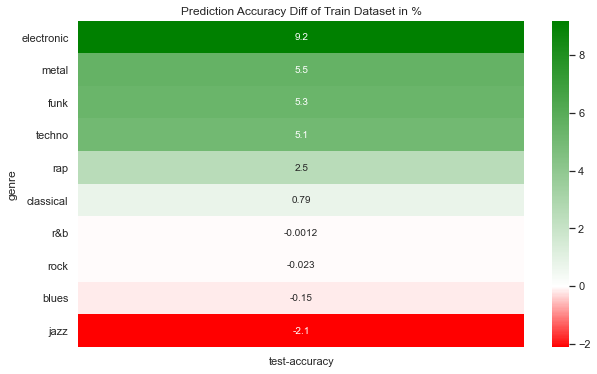

<Figure size 432x288 with 0 Axes>

In [19]:
from matplotlib.colors import LinearSegmentedColormap
fig, ax = plt.subplots(figsize=(10, 6))
_range = abs(heatmap_diff.max().max() - heatmap_diff.min().min())
zero_position = np.abs(heatmap_diff.min().min()) / _range
color_map_list = [(0, 'red'), (zero_position, 'white'), (1.0, "green")]

cmap = LinearSegmentedColormap.from_list('custom_cmap', color_map_list)
sns.heatmap(heatmap_diff, annot=True, cmap=cmap, annot_kws={'fontsize': 10})
# Plot data on a logarithmic scale
plt.title("Prediction Accuracy Diff of Train Dataset in %")
plt.figure()

## Now for the Test-Dataset

In [20]:
# Test Score of optimzed
test_scores_optimized_df = pd.DataFrame({"genre":[x.replace("genre_","") for x in test_scores_of_optimized.keys()], "score":test_scores_of_optimized.values()})
print("Score of Test Dataset")
test_scores_optimized_df

Score of Test Dataset


,genre,score
0,blues,0.8960
1,classical,0.9310
2,electronic,0.9105
3,funk,0.9070
4,jazz,0.8955
5,metal,0.9210
6,r&b,0.8945
7,rap,0.9340
8,rock,0.8940
9,techno,0.9440


In [21]:
heatmap_diff = test_scores_optimized_df.copy() 
heatmap_diff["score"] = heatmap_diff.score - test_scores_unoptimized_df.score
# we need to rotate it to visualize it properly 
#heatmap_diff = pd.DataFrame([x for x in ]heatmap_diff.genre)
#heatmap_diff=pd.DataFrame({x[0]:[x[1] * 100.0] for x in zip(heatmap_diff.genre, heatmap_diff.score)})
#heatmap_diff
heatmap_diff.index = heatmap_diff.genre
del heatmap_diff["genre"]
heatmap_diff["score"] = heatmap_diff.score.apply(lambda x: round(x * 100.0, 3))
heatmap_diff.sort_values(by='score', ascending=False, inplace=True)
heatmap_diff

,score
genre,
metal,1.40
rap,0.30
electronic,0.25
r&b,0.00
rock,0.00
blues,-0.15
funk,-0.55
techno,-1.25
jazz,-1.60


## Lets Visualize it!

<Figure size 432x288 with 0 Axes>

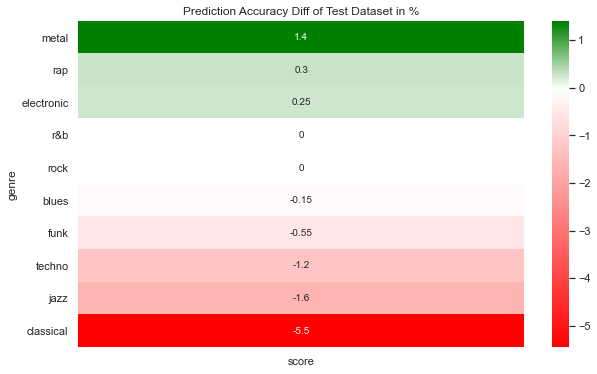

<Figure size 432x288 with 0 Axes>

In [22]:
from matplotlib.colors import LinearSegmentedColormap
fig, ax = plt.subplots(figsize=(10, 6))
_range = abs(heatmap_diff.max().max() - heatmap_diff.min().min())
zero_position = np.abs(heatmap_diff.min().min()) / _range
color_map_list = [(0, 'red'), (zero_position, 'white'), (1.0, "green")]

cmap = LinearSegmentedColormap.from_list('custom_cmap', color_map_list)
sns.heatmap(heatmap_diff, annot=True, cmap=cmap, annot_kws={'fontsize': 10})
# Plot data on a logarithmic scale
plt.title("Prediction Accuracy Diff of Test Dataset in %")
plt.figure()